## Exploratory analysis of the MM-WHS dataset

In [3]:
# imports 
import numpy as np
import os
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
)

import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk

# Example CT dataset

In [24]:
data_dir = "../MMWHS_Dataset/ct_train"
images = sorted(glob.glob(os.path.join(data_dir, "ct_train_*_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "ct_train_*_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))
print(example_dataset[18])

20
{'img': '../MMWHS_Dataset/ct_train/ct_train_1019_image.nii.gz', 'seg': '../MMWHS_Dataset/ct_train/ct_train_1019_label.nii.gz'}


In [5]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"), # normalization between 0 and 1
        EnsureTyped(keys=["img", "seg"]),
    ]
)

In [6]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:56<00:00, 56.96s/it]


In [7]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)

middle_image = check_data["img"][0, :, :, :, 170]
middle_label = check_data["seg"][0, :, :, :, 170]
print("image shape", middle_image.shape, "label shape", middle_label.shape)

first volume's shape torch.Size([1, 1, 512, 512, 363]) torch.Size([1, 1, 512, 512, 363])
image shape torch.Size([1, 512, 512]) label shape torch.Size([1, 512, 512])


In [8]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        #Resized(keys=["img", "seg"], spatial_size=[224, 224]),
        MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]),
    ]
)

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [9]:
i = 0
current_directory = os.getcwd()
output_dir_image = "preprocessed/ct_train/images"
output_dir_label = "preprocessed/ct_train/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    if torch.any(label.data != 0).item():
        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, f"slice_{i}.nii.gz"))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, f"slice_{i}.nii.gz"))
        i += 1
        break

print("Total number of slices:", i)

    

Total number of slices: 1


In [10]:
filename = "preprocessed/ct_train/images/slice_170.nii.gz"
example_im = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename)
print(f"image data shape: {example_im.shape}")

filename = "preprocessed/ct_train/labels/slice_170.nii.gz"
example_label = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename)
print(f"label data shape: {example_label.shape}")

image data shape: torch.Size([512, 512, 1, 1, 1])
label data shape: torch.Size([512, 512, 1, 1, 1])


first image shape torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/TensorShape.cpp:3614.)


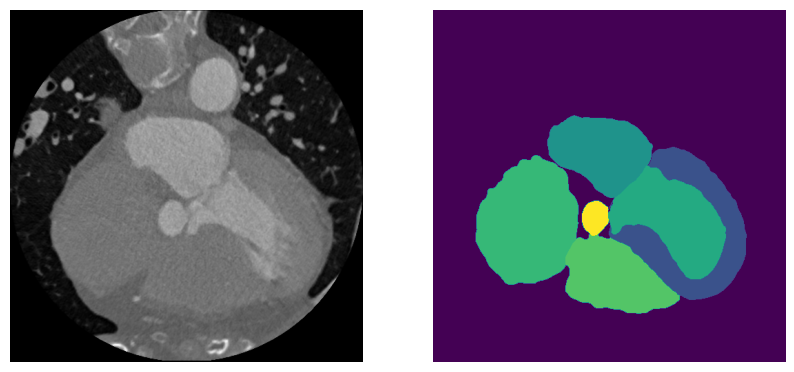

In [11]:
print("first image shape", middle_image.shape, middle_label.shape)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(middle_image.T, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(middle_label.T)


In [12]:
example_im = example_im.squeeze(3).squeeze(3)
example_label = example_label.squeeze(3).squeeze(3)

print("first image shape", middle_image.shape, middle_label.shape)
print("example image shape", example_im.shape, example_label.shape)

first image shape torch.Size([1, 512, 512]) torch.Size([1, 512, 512])
example image shape torch.Size([512, 512, 1]) torch.Size([512, 512, 1])


The image data are the same!


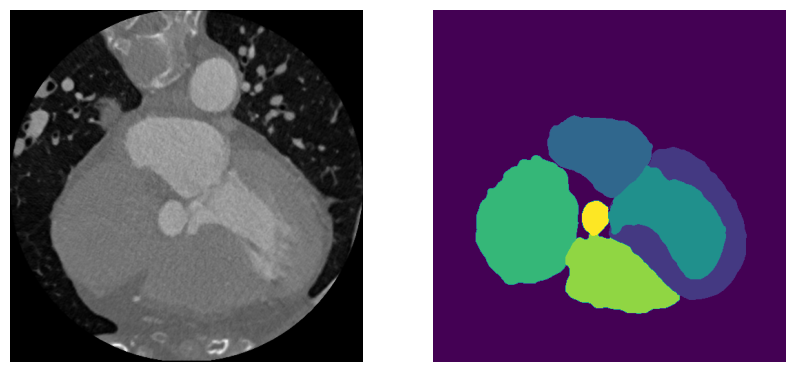

In [15]:
if torch.allclose(example_im, middle_image.T):# and torch.allclose(example_label, middle_label.T):
    print("The image data are the same!")
    # label is not the same due to chance in the MapLabelValued transform  

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label)